# Fluxonium

## Introduction

In this notebook, we calculate Fluxonium qubit properties such as energy spectrum, eigenfunctions, and decoherence rates for different loss channels.

## Circuit Description

The following Fluxonium qubit consists of an inductor with $E_L=0.46~\text{GHz}$ and Josephson Junction with $E_J=10.2~\text{GHz}$. The capacitor with $E_{C_J}=3.6~\text{GHz}$ is assigned to Josephson Junction rather than the inductor. 

<img src="pics/Fluxonium.png" width="185" align = "left"/>

Firstly, we import the SQcircuit and the relavant libraries

In [1]:
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt

We define the single inductive loop of the circuit via `Loop` class

In [2]:
loop1 = sq.Loop()

The elements of the circuit can be defined via `Capacitor`, `Inductor`, and `Junction` classes in SQcircuit, and to define the circuit, we use the `Circuit` class. 

In [3]:
# define the circuit elements
C = sq.Capacitor(3.6, 'GHz',Q=1e6 ,error=10)
L = sq.Inductor(0.46,'GHz',Q=500e6 ,loops=[loop1])
JJ = sq.Junction(10.2,'GHz',cap =C , A=1e-7, x=3e-06, loops=[loop1])

# define the circuit
elements = {
    (0, 1): [L, JJ]
}

cr = sq.Circuit(elements, flux_dist='all')

By creating an object of `Circuit` class, SQcircuit systematically finds the correct set of transformations and basis to make the circuit ready to be diagonalized.

Before setting the truncation numbers for each mode and diagonalizing the Hamiltonian, we can gain more insight into our circuit by calling the `description()` method. This prints out the Hamiltonian and a listing of the modes, whether they are harmonic or charge modes, and the frequency for each harmonic in GHz (the default unit). Moreover, it shows the prefactors in the Josephson junction part of the Hamiltonian $\tilde{\textbf{w}}_k$, which helps find the modes decoupled from the nonlinearity of the circuit.

In [4]:
cr.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We determinte the size of the Hilbert space and truncation number for the only mode of the circuit.

In [5]:
cr.set_trunc_nums([60])

To generate the spectrum and decoherence rates of the circuit, firstly, we need to change and sweep the external flux of `loop1` by the `set_flux()` method. Then, we need to find the eigenfrequencies and decherence rates of the circuit that correspond to that external flux via `diag()` and `dec_rate()` method. In the following lines of code the `spec` is a 2D NumPy array that each column of it contains the eigenfrequencies with respect to its external flux. The `decays` is a Python dictionary that contains the decoherence rates for each type of loss channel.

In [6]:
n_eig = 5

phiExt = np.linspace(0, 1, 500)

decays = {'capacitive':np.zeros_like(phiExt),
          'inductive':np.zeros_like(phiExt),
          'cc':np.zeros_like(phiExt),
          'quasiparticle':np.zeros_like(phiExt)}

spec = np.zeros((n_eig, len(phiExt)))

for i, phi in enumerate(phiExt):
    loop1.set_flux(phi)
    spec[:, i], _ = cr.diag(n_eig)
    for dec_type in decays:
        decays[dec_type][i]=cr.dec_rate(dec_type=dec_type, states=(1,0))

## Circuit Spectrum

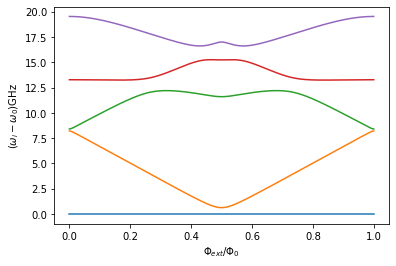

In [7]:
plt.figure()
for i in range(n_eig):
    plt.plot(phiExt, (spec[i, :] - spec[0, :]))

plt.xlabel(r"$\Phi_{ext}/\Phi_0$")
plt.ylabel(r"($\omega_i-\omega_0$)GHz")
plt.show()

## Decoherence Rates

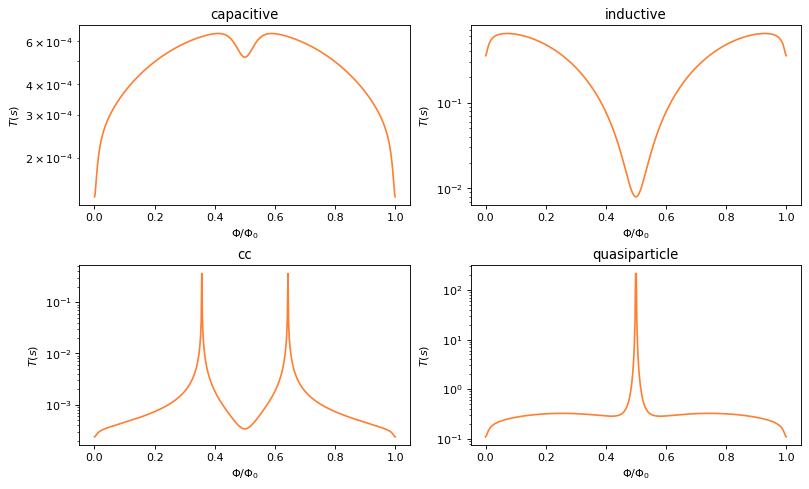

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True, dpi=80)
for dec_type, ax in zip(decays, axs.flat):
    ax.semilogy(phiExt, 1/decays[dec_type],'#ff7f32')
    ax.set_title(dec_type)
    ax.set_xlabel(r"$\Phi/\Phi_0$")
    ax.set_ylabel(r"$T(s)$")

## Eigenfunctions

We can get the phase space eigenfunction of a specific eigenvector of a circuit by using the `eig_phase_coord()` method. To calculate the eigenfunction at $\Phi_{ext} = 0.5\Phi_0$, we set back the flux of our loop to $0.5$ and diagonalize the `cr` again.

In [9]:
loop1.set_flux(0.5)
_, _ = cr.diag(5)

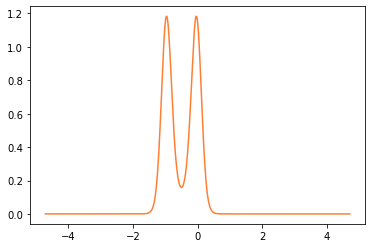

In [10]:
phi1= np.pi*np.linspace(-1.5,1.5,500)
# creat the grid list
grid = [phi1]

# the ground state
state0 = cr.eig_phase_coord(k=0, grid=grid)
plt.plot(phi1, np.abs(state0)**2, '#ff7f32')